In [117]:
import numpy as np
from numpy import inf
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap
import scipy
from scipy import io
import glob
import SAplotter
from SAplotter import *
from filedata import *
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from plotEO import plotEO
import aplpy
import copy
import glob

In [4]:
data = collector('new_source_arrays/1130788624_source_array.sav')
sep = separator(data)

In [ ]:
def fits_gethduaxis(HDU, axis, strict_fits=True):
    """
    Helper function for making axis arrays for fits files.
    Args:
        HDU: a fits HDU
        axis: the axis number of interest
        strict_fits: boolean
            If True, require that the axis has cooresponding NAXIS, CRVAL,
            CDELT and CRPIX keywords. If False, allow CRPIX to be missing and
            set it equal to zero (as a way of supporting old calfits files).
            Default is False.
    Returns:
        numpy array of values for that axis
    """

    ax = str(axis)
    N = HDU.header['NAXIS' + ax]
    X0 = HDU.header['CRVAL' + ax]
    dX = HDU.header['CDELT' + ax]
    # add this for calfits backwards compatibility when the CRPIX values were often assumed to be 0
    
    try:
        Xi0 = HDU.header['CRPIX' + ax] - 1
    except(KeyError):
        if not strict_fits:
            import calfits
            calfits._warn_oldcalfits('This file')
            Xi0 = 0
        else:
            raise
    
    return dX * (np.arange(N) - Xi0) + X0

hdu_list = fits.open('624_TGSSfits/ds9_28505.fits')

In [214]:
from astropy.wcs import WCS

def pixelate(RA_zoom, DEC_zoom, n_bins, RA_total, DEC_total, FLUX_total):
    import numpy as np
    #Check to see which dimension is larger so that a square in ra,DEC can 
    #be returned
    if (RA_zoom[1]-RA_zoom[0]) > (DEC_zoom[1]-DEC_zoom[0]):
        zoom = RA_zoom
    else:
        zoom = DEC_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and DEC that give the left side of each pixel
    
    RA_bin_array = (np.array(range(n_bins)) * binsize) + RA_zoom[0]
    DEC_bin_array = (np.array(range(n_bins)) * binsize) + DEC_zoom[0]
        
    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(RA_bin_array),len(DEC_bin_array)))

    #Histogram components into ra bins
    RA_histogram = np.digitize(RA_total,RA_bin_array)
    ###print RA_histogram

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(RA_bin_array) - 2):
        #Find the indices that fall into the current ra bin slice
        RA_inds = np.where(RA_histogram == bin_i)

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(RA_inds[0]) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by DEC
        DEC_histogram = np.digitize(DEC_total[RA_inds],DEC_bin_array)
        #Begin for loop by DEC over ra bin slice
        for bin_j in range(len(DEC_bin_array) -2):
            
            #Find the indicies that fall into the current DEC bin
            DEC_inds = np.where(DEC_histogram == bin_j)

            #Go to next for cycle if no indices fall into current DEC bin			
            if len(DEC_inds[0]) == 0:
                continue
            #Sum the FLUX components that fall into current ra/DEC bin
            pixels[bin_i,bin_j] = np.sum(FLUX_total[RA_inds[0][DEC_inds][0]])

    #Find the pixel centers in ra/DEC for plotting purposes
    RA_pixel_centers = (np.arange(n_bins) * binsize) + RA_zoom[0] + binsize/2.
    DEC_pixel_centers = (np.arange(n_bins) * binsize) + DEC_zoom[0] + binsize/2.

    return pixels, RA_pixel_centers, DEC_pixel_centers

def pixelater(RA_zoom, DEC_zoom, n_bins, RA_total, DEC_total, flux_total):
    import numpy as np
    #Check to see which dimension is larger so that a square in ra,DEC can 
    #be returned
    if (RA_zoom[1]-RA_zoom[0]) > (DEC_zoom[1]-DEC_zoom[0]):
        zoom = RA_zoom
    else:
        zoom = DEC_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and DEC that give the left side of each pixel
    spacing_DEC = ((RA_zoom[1]-RA_zoom[0]) - (DEC_zoom[1]-DEC_zoom[0]))/2.
    spacing_RA = ((DEC_zoom[1]-DEC_zoom[0])-(RA_zoom[1]-RA_zoom[0]))/2.
    
    RA_bin_array = (np.array(range(n_bins)) * binsize) + RA_zoom[0]
    DEC_bin_array = (np.array(range(n_bins)) * binsize) + DEC_zoom[0]
    
    
    #hashing this out restores this to the original pixelate function.
    '''
    if (RA_zoom[1]-RA_zoom[0]) > (DEC_zoom[1]-DEC_zoom[0]):
        DEC_bin_array = (np.array(range(n_bins)) * binsize) + DEC_zoom[0] - spacing_DEC
    if (RA_zoom[1]-RA_zoom[0]) < (DEC_zoom[1]-DEC_zoom[0]):
        RA_bin_array = (np.array(range(n_bins)) * binsize) + RA_zoom[0] - spacing_RA
    '''
    
    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(RA_bin_array),len(DEC_bin_array)))

    #Histogram components into ra bins
    RA_histogram = np.digitize(RA_total,RA_bin_array)
    ###print RA_histogram

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(RA_bin_array) - 2):
        ###print range(len(RA_bin_array) -2
        ###print "bin_i",bin_i
        #Find the indices that fall into the current ra bin slice
        RA_inds = np.where(RA_histogram == bin_i)
        ###print "rainds", RA_inds[0]
        ###print "lenrainds", len(RA_inds[0])

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(RA_inds[0]) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by DEC
        #print "DECtotindex", DEC_total[RA_inds]
        #print "DECbin", DEC_bin_array
        DEC_histogram = np.digitize(DEC_total[RA_inds],DEC_bin_array)
        #print "DEChist",DEC_histogram
        #Begin for loop by DEC over ra bin slice
        for bin_j in range(len(DEC_bin_array) -2):
            
            #Find the indicies that fall into the current DEC bin
            DEC_inds = np.where(DEC_histogram == bin_j)

            #Go to next for cycle if no indices fall into current DEC bin			
            if len(DEC_inds[0]) == 0:
                continue
            #Sum the flux components that fall into current ra/DEC bin
            ###print "bi",bin_i,bin_j
            ###print "inds",RA_inds, DEC_inds
            pixels[bin_i,bin_j] = np.sum(flux_total[RA_inds[0][DEC_inds][0]])

    #Find the pixel centers in ra/DEC for plotting purposes
    RA_pixel_centers = (np.arange(n_bins) * binsize) + RA_zoom[0] + binsize/2.
    DEC_pixel_centers = (np.arange(n_bins) * binsize) + DEC_zoom[0] + binsize/2.

    return pixels, RA_pixel_centers, DEC_pixel_centers, spacing_DEC, spacing_RA

def framer(RA,DEC):
    min_RA, max_RA, min_DEC, max_DEC = min(RA), max(RA), min(DEC), max(DEC)
    min_degrees = 50
    x = max_RA - min_RA
    y = max_DEC - min_DEC
    z = .25 * max(x,y)
    if (x > y) and (x - y > min_degrees/3600.):
        RA_zoom_min = min_RA - z
        RA_zoom_max = max_RA + z
        DEC_zoom_min = min_DEC - .5*(x-y) - z
        DEC_zoom_max = max_DEC + .5*(x-y) + z
    elif (y > x) and (y - x > min_degrees/3600.):
        RA_zoom_min = min_RA - .5*(y-x) - z
        RA_zoom_max = max_RA + .5*(y-x) + z
        DEC_zoom_min = min_DEC - z
        DEC_zoom_max = max_DEC + z
    else:
        RA_zoom_min = RA[0] - .1
        RA_zoom_max = RA[-1] + .1
        DEC_zoom_min = DEC[0] - .1
        DEC_zoom_max = DEC[-1] + .1
    return {'RA_zoom_min': RA_zoom_min, 'RA_zoom_max': RA_zoom_max,
            'DEC_zoom_min': DEC_zoom_min, 'DEC_zoom_max': DEC_zoom_max}

def framez(min_RA, max_RA, min_DEC, max_DEC):
    #min_RA, max_RA, min_DEC, max_DEC = min(RA), max(RA), min(DEC), max(DEC)
    x = max_RA - min_RA
    y = max_DEC - min_DEC
    z = .5 * max(x,y)
    
    if x > y:
        RA_zoom_min = min_RA - z
        RA_zoom_max = max_RA + z
        DEC_zoom_min = min_DEC - .5*(x-y) - z
        DEC_zoom_max = max_DEC + .5*(x-y) + z
    elif y > x:
        RA_zoom_min = min_RA - .5*(x-y) - z
        RA_zoom_max = max_RA + .5*(x-y) + z
        DEC_zoom_min = min_DEC - z
        DEC_zoom_max = max_DEC + z
        
    return RA_zoom_min, RA_zoom_max, DEC_zoom_min, DEC_zoom_max

def all_seeker(data):
    
    separated = separator(data)
    
    
    indexed_point_sources_RA = [[separated['psources'][i][j]['RA']
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]
    indexed_point_sources_DEC = [[separated['psources'][i][j]['DEC']
                                  for j in range(len(separated['psources'][i]))]
                                 for i in range(len(separated['psources']))]
    indexed_point_sources_FLUX = [[separated['psources'][i][j]['FLUX']['I'][0]
                                for j in range(len(separated['psources'][i]))]
                               for i in range(len(separated['psources']))]
    indexed_point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0]
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]
    indexed_point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0]
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]
    indexed_EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]
    indexed_EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k]
                                for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))]
                               for j in range(len(separated['extsources'][i]))]
                              for i in range(len(separated['extsources']))]
    indexed_EO_sources_FLUX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0]
                              for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                             for j in range(len(separated['extsources'][i]))]
                            for i in range(len(separated['extsources']))]
    indexed_EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]
    indexed_EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]

    for i in range(len(data['data'])):
        for j in range(len(indexed_EO_sources_RA[i])):
            for k in range(len(indexed_EO_sources_RA[i][j])):
                if indexed_EO_sources_RA[i][j][k] > 180:
                    indexed_EO_sources_RA[i][j][k] -= 360
        for j in range(len(indexed_point_sources_RA[i])):
            if indexed_point_sources_RA[i][j] > 180:
                indexed_point_sources_RA[i][j] -= 360

    all_RA = [[indexed_point_sources_RA[i][j]
               for j in range(len(indexed_point_sources_RA[i]))] + [indexed_EO_sources_RA[i][j][k]
              for j in range(len(indexed_EO_sources_RA[i]))
              for k in range(len(indexed_EO_sources_RA[i][j]))]
              for i in range(len(data['data']))]
    all_DEC = [[indexed_point_sources_DEC[i][j]
                for j in range(len(indexed_point_sources_DEC[i]))] + [indexed_EO_sources_DEC[i][j][k]
               for j in range(len(indexed_EO_sources_DEC[i]))
               for k in range(len(indexed_EO_sources_DEC[i][j]))]
               for i in range(len(data['data']))]
    all_FLUX = [[indexed_point_sources_FLUX[i][j]
              for j in range(len(indexed_point_sources_FLUX[i]))] + [indexed_EO_sources_FLUX[i][j][k]
             for j in range(len(indexed_EO_sources_FLUX[i]))
             for k in range(len(indexed_EO_sources_FLUX[i][j]))]
             for i in range(len(data['data']))]
    all_XX = [[indexed_point_sources_XX[i][j]
               for j in range(len(indexed_point_sources_XX[i]))] + [indexed_EO_sources_XX[i][j][k]
              for j in range(len(indexed_EO_sources_XX[i]))
              for k in range(len(indexed_EO_sources_XX[i][j]))]
              for i in range(len(data['data']))]
    all_YY = [[indexed_point_sources_YY[i][j]
               for j in range(len(indexed_point_sources_YY[i]))] + [indexed_EO_sources_YY[i][j][k]
              for j in range(len(indexed_EO_sources_YY[i]))
              for k in range(len(indexed_EO_sources_YY[i][j]))]
              for i in range(len(data['data']))]
    all_BEAM = [np.asarray(np.asarray(all_XX[i]) + np.asarray(all_YY[i])) /
                np.asarray(all_FLUX[i]) for i in range(len(data['data']))]
    
    return {'indexed_point_sources_RA': indexed_point_sources_RA, 'indexed_point_sources_DEC': indexed_point_sources_DEC,
            'indexed_point_sources_FLUX': indexed_point_sources_FLUX, 'indexed_point_sources_XX': indexed_point_sources_XX,
            'indexed_point_sources_YY': indexed_point_sources_YY, 'indexed_EO_sources_RA': indexed_EO_sources_RA,
            'indexed_EO_sources_DEC': indexed_EO_sources_DEC, 'indexed_EO_sources_FLUX': indexed_EO_sources_FLUX,
            'indexed_EO_sources_XX': indexed_EO_sources_XX, 'indexed_EO_sources_YY': indexed_EO_sources_YY,
            'all_RA': all_RA, 'all_DEC': all_DEC, 'all_FLUX': all_FLUX, 'all_XX': all_XX, 'all_YY': all_YY,
            'all_BEAM': all_BEAM}

def sidebyside(data,fits_file,minI=0,sumI=0,binwidth=2,sigmawidth=4,EOid=None):
    from matplotlib.colors import LogNorm
    from matplotlib.colorbar import Colorbar
    import matplotlib.patches as patches
    from scipy.stats import iqr
    from scipy.stats.kde import gaussian_kde
    import matplotlib.gridspec as gridspec
    import re
    from astropy.convolution import convolve, convolve_fft
    from astropy.convolution import Gaussian2DKernel
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    import matplotlib.mlab as mlab
    from astropy.wcs import WCS
    from astropy.io import fits
    import astropy.wcs as wcs
    
    separated = separator(data)
    '''
    binwidth = binwidth * (1./3600.) #Converting binwidth in arcsec to degrees
    sigmawidth = sigmawidth * (1./3600.) #Converting binwidth in arcsec to degrees
    
    indexed_point_sources_RA = [[separated['psources'][i][j]['RA'] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_point_sources_DEC = [[separated['psources'][i][j]['DEC'] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_point_sources_I = [[separated['psources'][i][j]['FLUX']['I'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]
    
    indexed_point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]
    
    indexed_point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    indexed_EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    indexed_EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    for i in range(len(data['data'])):
        for j in range(len(indexed_EO_sources_RA[i])):
            for k in range(len(indexed_EO_sources_RA[i][j])):
                if indexed_EO_sources_RA[i][j][k] > 180:
                    indexed_EO_sources_RA[i][j][k] -= 360
        for j in range(len(indexed_point_sources_RA[i])):
            if indexed_point_sources_RA[i][j] > 180:
                indexed_point_sources_RA[i][j] -= 360    
    
    all_RA = [[indexed_point_sources_RA[i][j] \
        for j in range(len(indexed_point_sources_RA[i]))] \
        + [indexed_EO_sources_RA[i][j][k] \
        for j in range(len(indexed_EO_sources_RA[i])) \
        for k in range(len(indexed_EO_sources_RA[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_DEC = [[indexed_point_sources_DEC[i][j] \
        for j in range(len(indexed_point_sources_DEC[i]))] \
        + [indexed_EO_sources_DEC[i][j][k] \
        for j in range(len(indexed_EO_sources_DEC[i])) \
        for k in range(len(indexed_EO_sources_DEC[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_I = [[indexed_point_sources_I[i][j] \
        for j in range(len(indexed_point_sources_I[i]))] \
        + [indexed_EO_sources_I[i][j][k] \
        for j in range(len(indexed_EO_sources_I[i])) \
        for k in range(len(indexed_EO_sources_I[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_XX = [[indexed_point_sources_XX[i][j] \
        for j in range(len(indexed_point_sources_XX[i]))] \
        + [indexed_EO_sources_XX[i][j][k] \
        for j in range(len(indexed_EO_sources_XX[i])) \
        for k in range(len(indexed_EO_sources_XX[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_YY = [[indexed_point_sources_YY[i][j] \
        for j in range(len(indexed_point_sources_YY[i]))] \
        + [indexed_EO_sources_YY[i][j][k] \
        for j in range(len(indexed_EO_sources_YY[i])) \
        for k in range(len(indexed_EO_sources_YY[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_beam = [np.asarray(np.asarray(all_XX[i]) + np.asarray(all_YY[i])) / np.asarray(all_I[i]) for i in range(len(data['data']))]
    #print all_beam[0]
    #print all_beam[1]
    
    kernel = Gaussian2DKernel(stddev=(sigmawidth/binwidth))
    semi_zoom = 3
    pixelreplacement = 1e-5
    cmap = matplotlib.cm.get_cmap('gist_heat')

    for i in range(len(data['data'])):
        
        #---------- Pixelating and convolving All Plot
        all_RA_zoom = [min(all_RA[i]),max(all_RA[i])]
        all_DEC_zoom = [min(all_DEC[i]),max(all_DEC[i])]
        all_n_bins = min(int(max(max(all_RA[i]) - min(all_RA[i]),max(all_DEC[i]) - min(all_DEC[i])) / binwidth),1024)
        all_RA_total = np.array(all_RA[i])
        all_DEC_total = np.array(all_DEC[i])
        all_I_total = np.array(all_I[i])
        all_XX_total = np.array(all_XX[i])
        all_YY_total = np.array(all_YY[i])
        
        all_beam_total = np.array(all_beam[i])
        
        (all_pixels, all_RA_pixel_centers, all_DEC_pixel_centers, spacing_DEC, spacing_RA) = \
                pixelater(all_RA_zoom,all_DEC_zoom,all_n_bins,all_RA_total,all_DEC_total,all_I_total)
            
        (all_pixels_contour, all_RA_pixel_centers_contour, all_DEC_pixel_centers_contour, spacing_DEC, spacing_RA) = \
                    pixelater(all_RA_zoom,all_DEC_zoom,50,all_RA_total,all_DEC_total,all_beam_total)
        
        all_pixels[all_pixels == 0] = pixelreplacement
        all_convolved = convolve_fft(all_pixels, kernel)
        if EOid != None:
            minI, sumI = 0, 0
            
        
        for j in range(len(separated['extsources'][i])):
            if (EOid is not None) and (separated['extsources'][i][j]['ID'] != EOid):
                continue
                
            elif ((max(indexed_EO_sources_I[i][j]) > minI) or (sum(indexed_EO_sources_I[i][j]) > sumI))\
            and ((max(indexed_EO_sources_XX[i][j]) != 0) and (max(indexed_EO_sources_YY[i][j]) != 0)):
                #---------- Pixelating and convolving EO Plot
                EO_RA_zoom = [min(indexed_EO_sources_RA[i][j]),max(indexed_EO_sources_RA[i][j])]
                EO_DEC_zoom = [min(indexed_EO_sources_DEC[i][j]),max(indexed_EO_sources_DEC[i][j])]                
                EO_RA_total = np.array(indexed_EO_sources_RA[i][j])
                EO_DEC_total = np.array(indexed_EO_sources_DEC[i][j])
                EO_I_total = np.array(indexed_EO_sources_I[i][j])
                
                print 'EO_RA_zoom[0], EO_RA_zoom[1], EO_DEC_zoom[0], EO_DEC_zoom[1]',EO_RA_zoom[0], EO_RA_zoom[1], EO_DEC_zoom[0], EO_DEC_zoom[1]
                
                #EO_RA_zoom[0], EO_RA_zoom[1], EO_DEC_zoom[0], EO_DEC_zoom[1] = \
                #framez(EO_RA_zoom[0], EO_RA_zoom[1], EO_DEC_zoom[0], EO_DEC_zoom[1])
                
                frame = 0.02
                
                EO_RA_zoom[0] -= frame
                EO_DEC_zoom[0] -= frame
                EO_RA_zoom[1] += frame
                EO_DEC_zoom[1] += frame
                
                print 'EO_RA_zoom[0], EO_RA_zoom[1], EO_DEC_zoom[0], EO_DEC_zoom[1]',EO_RA_zoom[0], EO_RA_zoom[1], EO_DEC_zoom[0], EO_DEC_zoom[1]
                
                EO_n_bins = int(max(max(EO_RA_total) - min(EO_RA_total),max(EO_DEC_total) - min(EO_DEC_total)) / binwidth)
                #print EO_n_bins
                #print separated['extsources'][i][j]['ID']
                (EO_pixels, EO_RA_pixel_centers, EO_DEC_pixel_centers, spacing_DEC, spacing_RA) = \
                pixelater(EO_RA_zoom,EO_DEC_zoom,EO_n_bins,EO_RA_total,EO_DEC_total,EO_I_total)
                
                EO_pixels[EO_pixels == 0] = pixelreplacement
                EO_convolved = convolve_fft(EO_pixels, kernel)
                #---------- Pixelating and convolving Semi Plot
                semi_RA_zoom = [min(indexed_EO_sources_RA[i][j])-semi_zoom,max(indexed_EO_sources_RA[i][j])+semi_zoom]
                semi_DEC_zoom = [min(indexed_EO_sources_DEC[i][j])-semi_zoom,max(indexed_EO_sources_DEC[i][j])+semi_zoom]
                semi_n_bins = min(int(max([semi_RA_zoom[1]-semi_RA_zoom[0],semi_DEC_zoom[1]-semi_DEC_zoom[0]])/binwidth),512)
                semi_RA_total = np.array(all_RA[i])
                semi_DEC_total = np.array(all_DEC[i])
                semi_flux_total = np.array(all_I[i])

                (semi_pixels, semi_RA_pixel_centers, semi_DEC_pixel_centers, spacing_DEC, spacing_RA) = \
                        pixelater(semi_RA_zoom,semi_DEC_zoom,semi_n_bins,semi_RA_total,semi_DEC_total,semi_flux_total)

                semi_pixels[semi_pixels == 0] = pixelreplacement
                semi_convolved = convolve_fft(semi_pixels, kernel)
                '''
                #######################################################################
    sought = all_seeker(data)
    
    indexed_point_sources_RA = copy.deepcopy(sought['indexed_point_sources_RA'])
    indexed_point_sources_DEC = copy.deepcopy(sought['indexed_point_sources_DEC'])
    indexed_point_sources_FLUX = copy.deepcopy(sought['indexed_point_sources_FLUX'])
    indexed_point_sources_XX = copy.deepcopy(sought['indexed_point_sources_XX'])
    indexed_point_sources_YY = copy.deepcopy(sought['indexed_point_sources_YY'])
    indexed_EO_sources_RA = copy.deepcopy(sought['indexed_EO_sources_RA'])
    indexed_EO_sources_DEC = copy.deepcopy(sought['indexed_EO_sources_DEC'])
    indexed_EO_sources_FLUX = copy.deepcopy(sought['indexed_EO_sources_FLUX'])
    indexed_EO_sources_XX = copy.deepcopy(sought['indexed_EO_sources_XX'])
    indexed_EO_sources_YY = copy.deepcopy(sought['indexed_EO_sources_YY'])
    all_RA = copy.deepcopy(sought['all_RA'])
    all_DEC = copy.deepcopy(sought['all_DEC'])
    all_FLUX = copy.deepcopy(sought['all_FLUX'])
    all_XX = copy.deepcopy(sought['all_XX'])
    all_YY = copy.deepcopy(sought['all_YY'])
    all_BEAM = copy.deepcopy(sought['all_BEAM'])
    
    binwidth = binwidth * (1. / 3600.) # Converting binwidth in arcsec to degrees
    sigmawidth = sigmawidth * (1. / 3600.) # Converting binwidth in arcsec to degrees
    kernel = Gaussian2DKernel(stddev=(sigmawidth / binwidth))
    semi_zoom = 100. / 60.
    pixelreplacement = 1e-5
    cmap = matplotlib.cm.get_cmap('gist_heat')

    for i in range(len(data['data'])):
        if EOid is not None:
            sumI = 0
            
        # ---------- Pixelating and convolving All Plot
        all_framed = framer(all_RA[i],all_DEC[i])
        all_RA_zoom = [all_framed['RA_zoom_min'],all_framed['RA_zoom_max']]
        all_DEC_zoom = [all_framed['DEC_zoom_min'],all_framed['DEC_zoom_max']]
        all_n_bins = min(int(max(all_RA_zoom[1] - all_RA_zoom[0],
                                     all_DEC_zoom[1] - all_DEC_zoom[0]) / binwidth), 1024)
        all_RA_total = np.array(all_RA[i])
        all_DEC_total = np.array(all_DEC[i])
        all_FLUX_total = np.array(all_FLUX[i])
        all_XX_total = np.array(all_XX[i])
        all_YY_total = np.array(all_YY[i])
        all_BEAM_total = np.array(all_BEAM[i])
        (all_pixels, all_RA_pixel_centers, all_DEC_pixel_centers) = pixelate(
            all_RA_zoom, all_DEC_zoom, all_n_bins, all_RA_total, all_DEC_total, all_FLUX_total)
        (all_pixels_contour, all_RA_pixel_centers_contour, all_DEC_pixel_centers_contour) = pixelate(
            all_RA_zoom, all_DEC_zoom, 50, all_RA_total, all_DEC_total, all_BEAM_total)
        all_pixels[all_pixels == 0] = pixelreplacement
        all_convolved = convolve_fft(all_pixels, kernel)

        for j in range(len(separated['extsources'][i])):

            if (EOid is not None) and (separated['extsources'][i][j]['ID'] != EOid):
                continue

            if (sum(indexed_EO_sources_FLUX[i][j]) > sumI) and ((max(indexed_EO_sources_XX[i][j]) != 0) and (max(indexed_EO_sources_YY[i][j]) != 0)):
                # ---------- Pixelating and convolving EO Plot
                EO_framed = framer(indexed_EO_sources_RA[i][j],indexed_EO_sources_DEC[i][j])
                EO_RA_zoom = [EO_framed['RA_zoom_min'],EO_framed['RA_zoom_max']]
                EO_DEC_zoom = [EO_framed['DEC_zoom_min'],EO_framed['DEC_zoom_max']]
                EO_RA_total = np.array(indexed_EO_sources_RA[i][j])
                EO_DEC_total = np.array(indexed_EO_sources_DEC[i][j])
                EO_FLUX_total = np.array(indexed_EO_sources_FLUX[i][j])
                EO_n_bins = int(max(EO_RA_zoom[1] - EO_RA_zoom[0],
                                    EO_DEC_zoom[1] - EO_DEC_zoom[0]) / binwidth)
                (EO_pixels, EO_RA_pixel_centers, EO_DEC_pixel_centers) = pixelate(
                    EO_RA_zoom, EO_DEC_zoom, EO_n_bins, EO_RA_total, EO_DEC_total, EO_FLUX_total)
                EO_pixels[EO_pixels == 0] = pixelreplacement
                EO_convolved = convolve(EO_pixels, kernel)

                # ---------- Pixelating and convolving EO Not Plot
                EO_not_RA_zoom = EO_RA_zoom
                EO_not_DEC_zoom = EO_DEC_zoom
                EO_not_RA_total = np.array(all_RA[i])
                EO_not_DEC_total = np.array(all_DEC[i])
                EO_not_FLUX_total = np.array(all_FLUX[i])
                EO_not_n_bins = EO_n_bins
                (EO_not_pixels, EO_not_RA_pixel_centers, EO_not_DEC_pixel_centers) = pixelate(
                    EO_not_RA_zoom, EO_not_DEC_zoom, EO_not_n_bins, EO_not_RA_total, EO_not_DEC_total, EO_not_FLUX_total)
                EO_not_pixels[EO_not_pixels == 0] = pixelreplacement
                EO_not_convolved = convolve_fft(EO_not_pixels, kernel)

                # ---------- Pixelating and convolving Semi Plot
                print EO_framed['RA_zoom_min'], EO_framed['RA_zoom_max']
                semi_RA_zoom = [EO_framed['RA_zoom_min'] - semi_zoom, EO_framed['RA_zoom_max'] + semi_zoom]
                semi_DEC_zoom = [EO_framed['DEC_zoom_min'] - semi_zoom, EO_framed['DEC_zoom_max'] + semi_zoom]
                semi_n_bins = min(int(max([semi_RA_zoom[1] - semi_RA_zoom[0],
                                           semi_DEC_zoom[1] - semi_DEC_zoom[0]]) / binwidth), 512)
                semi_RA_total = np.array(all_RA[i])
                semi_DEC_total = np.array(all_DEC[i])
                semi_FLUX_total = np.array(all_FLUX[i])
                (semi_pixels, semi_RA_pixel_centers, semi_DEC_pixel_centers) = pixelate(
                    semi_RA_zoom, semi_DEC_zoom, semi_n_bins, semi_RA_total, semi_DEC_total, semi_FLUX_total)
                semi_pixels[semi_pixels == 0] = pixelreplacement
                semi_convolved = convolve_fft(semi_pixels, kernel)

                hist_RA = indexed_EO_sources_RA[i][j]
                hist_DEC = indexed_EO_sources_DEC[i][j]
                hist_FLUX = indexed_EO_sources_FLUX[i][j]
       
        
                #######################################################################
                
                '''
                PLOTTING!
                '''
    
                fig = plt.figure(figsize=(30,10))
    
                fig.suptitle('EO Source {} from ObsID {}'.format\
                    (separated['extsources'][i][j]['ID'],\
                    [int(s) for s in re.findall('\d+',data['filenames'][i])][0],\
                    separated['extsources'][i][j]['FREQ']), fontsize = 30)
    
                ax1 = fig.add_axes([0.0,0.1,0.7,0.7])
                
                EO_plot = ax1.imshow(np.transpose(EO_convolved), \
                    norm = LogNorm(vmin=pixelreplacement),\
                    origin = "lower", interpolation = "none", cmap = cmap,\
                    extent = [EO_RA_pixel_centers[0], EO_RA_pixel_centers[-1], \
                    EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1]] )
                
                contour_plot_1 = ax1.contour(np.transpose(EO_convolved), colors=('green'), vmin=0, alpha=.8, extent=[EO_RA_pixel_centers[0], EO_RA_pixel_centers[-1], \
                    EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1]],norm=LogNorm())
                
                ax1.patch.set_alpha(0.0)
                ax1.set_xlabel('RA')
                ax1.set_ylabel('DEC')
                ax1.minorticks_on()
                ax1.set_title('Plot of EO from MWA data')
    
                ax1.set_xlim(ax1.get_xlim()[::-1])
                ax1.set_xlim(EO_RA_pixel_centers[-1], EO_RA_pixel_centers[0])
                ax1.set_ylim(EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1])
    
                #these four variables are used to center the TGSS plot
    
                RA_center = (EO_RA_pixel_centers[-1] + EO_RA_pixel_centers[0]) / 2
                DEC_center = (EO_DEC_pixel_centers[-1] + EO_DEC_pixel_centers[0]) / 2
                RA_radius = abs((EO_RA_pixel_centers[-1] - EO_RA_pixel_centers[0]) / 2)
                DEC_radius = abs((EO_DEC_pixel_centers[-1] - EO_DEC_pixel_centers[0]) / 2)
                
                #second plot uses aplpy module to plot FITS file from TGSS
    
                f = aplpy.FITSFigure(fits_file,figure=fig,subplot=[0.3,0.1,0.7,0.7])
                f.show_colorscale(cmap='hot',vmin=0)
                f.show_contour(fits_file,layer='tgss',colors='blue',norm=LogNorm())                
                
                f.add_grid()
                f.add_colorbar()
                f.set_nan_color('black')
                f.recenter(RA_center,DEC_center,RA_radius,DEC_radius)
                
                f.set_title('Plot of EO from TGSS')
                f.set_xaxis_coord_type('scalar')
                f.set_yaxis_coord_type('scalar')
                f.tick_labels.set_xformat('%11.3f')
                f.tick_labels.set_yformat('%11.3f')       
                
                #third plot is TGSS file with MWA contour
                
                f2 = aplpy.FITSFigure(fits_file,figure=fig,subplot=[0.604,0.1,0.7,0.7])
                f2.show_colorscale(cmap='hot',vmin=0,aspect='equal')
                #axf2 = fig.get_axes()
                #axf2.get_shared_x_axes().join(ax1, ax2)
                
                f2.add_grid()
                f2.add_colorbar()
                f2.set_nan_color('black')
                f2.recenter(RA_center,DEC_center,RA_radius,DEC_radius)
                f2.remove_colorbar()
                f2.set_title('TGSS EO Plot with MWA Contours')
                
                f2.set_xaxis_coord_type('scalar')
                f2.set_yaxis_coord_type('scalar')
                f2.tick_labels.set_xformat('%11.3f')
                f2.tick_labels.set_yformat('%11.3f')
                
                ax2 = fig.add_axes([0.6,0.1,0.7,0.7])
                
                ax2.set_aspect('equal')
                
                
                contour_plot_2 = ax2.contour(np.transpose(EO_convolved), colors=('green'), vmin=0, alpha=.8, extent=[EO_RA_pixel_centers[-1], EO_RA_pixel_centers[0], \
                    EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1]], norm = LogNorm() )
                
                ax2.patch.set_alpha(0.0)
                
                ax2.set_xlim(ax2.get_xlim()[::-1])
                ax2.set_xlim(EO_RA_pixel_centers[0], EO_RA_pixel_centers[-1])
                ax2.set_ylim(EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1])
                
                ax2.minorticks_off()
                ax2.axes.get_xaxis().set_visible(False)
                ax2.axes.get_yaxis().set_visible(False)
                
                #plt.savefig('/home/champ8/uwchamp2017/tgss_mwa/1130788624/contourEO'+'{}'.format(separated['extsources'][i][j]['ID'])+'.png', bbox_inches='tight')
    return plt.show()

81.2106981277 81.4974241257
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmax to  3.285e-01 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmax to  3.285e-01 [aplpy.core]


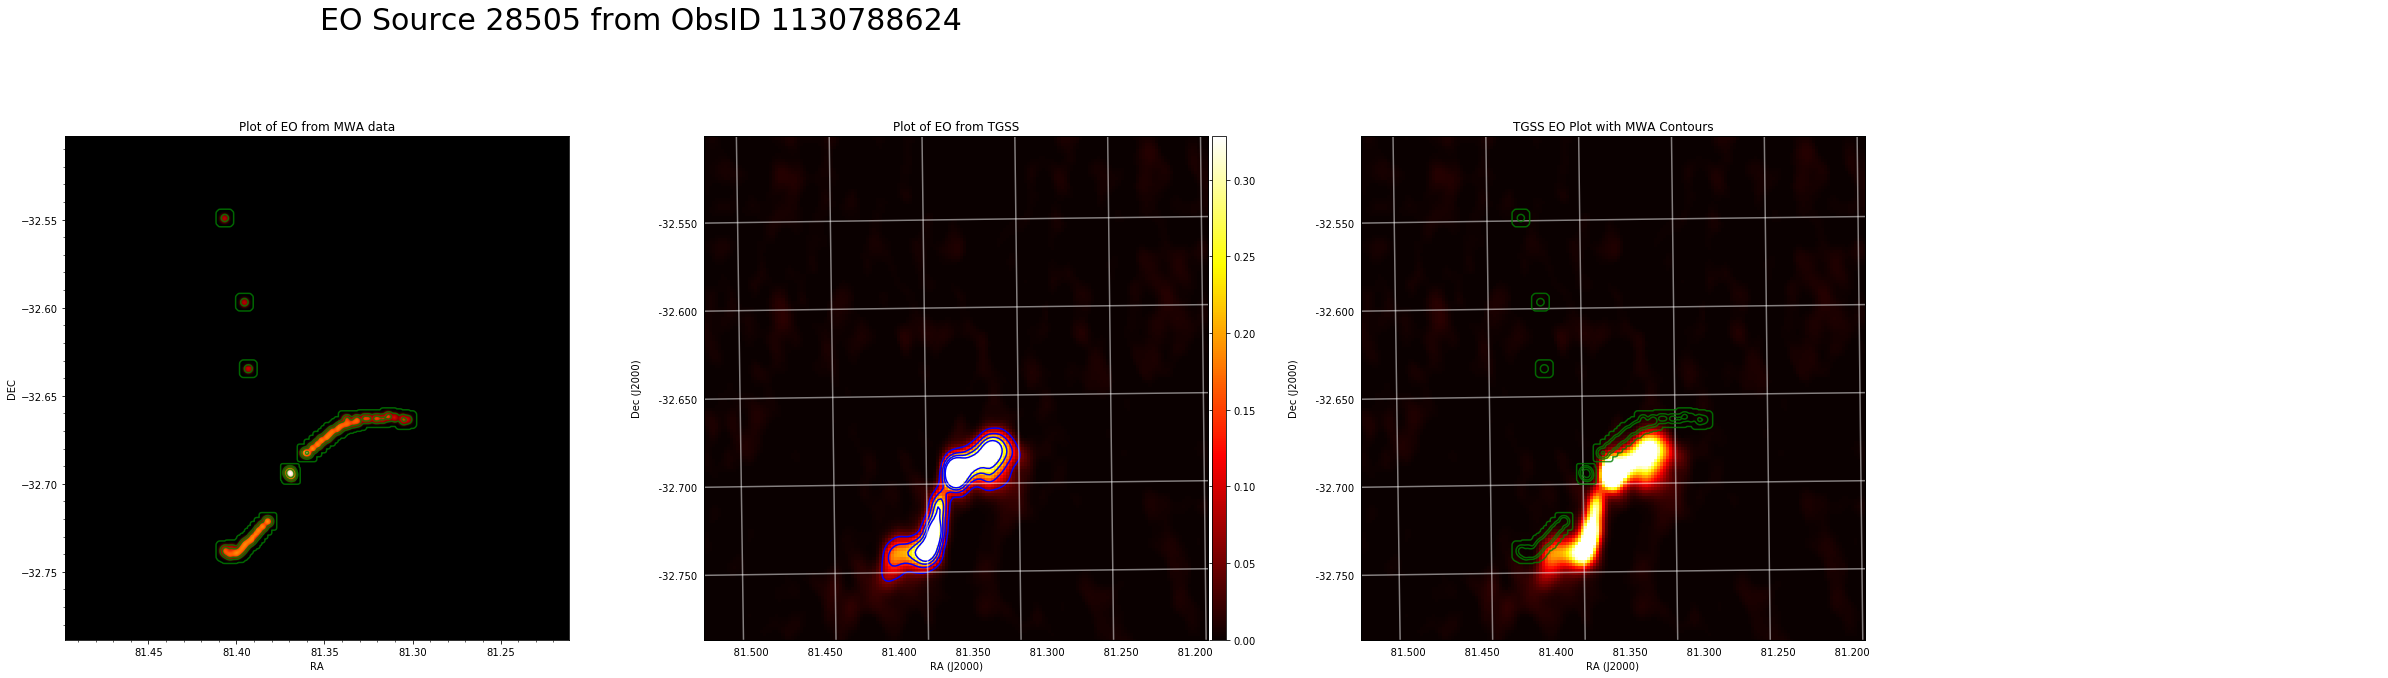

None


In [215]:
print sidebyside(data,'624_TGSSfits/624_28505.FITS',EOid=28505)

80.5394954681 80.7457294464
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmax to  2.809e-01 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmax to  2.809e-01 [aplpy.core]


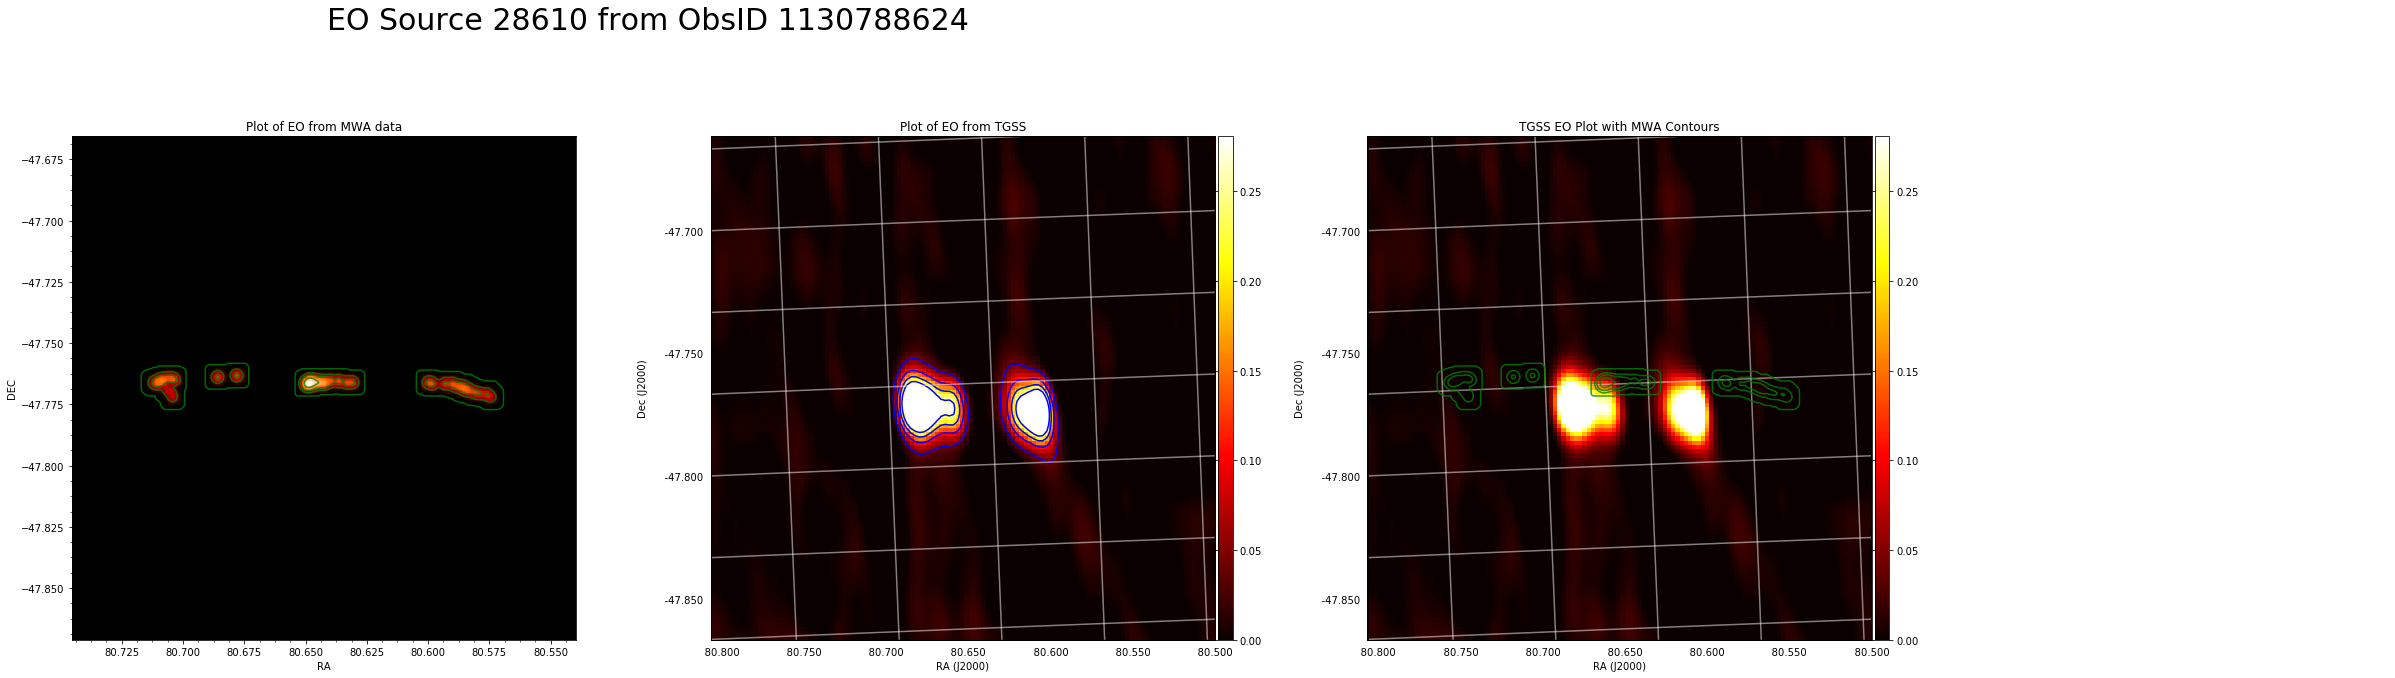

None


In [162]:
print sidebyside(data,'624_TGSSfits/624_28610.FITS',EOid=28610)